In [1]:
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
import os
import os.path
from time import perf_counter
import spx_strategies as ss
import optuna


#########################
# Settings for backtest #
#########################
# Delta values must be scaled from 0.0 to 1.0 (0 delta to 100 delta)
delta_sp = 0.214
delta_lp = 0.001
delta_sc = 0.201
delta_lc = 0.001
delta_params = {'delta_sp':delta_sp, 'delta_lp':delta_lp, 'delta_sc':delta_sc,'delta_lc':delta_lc}

same_day = True
purchase_time = '09:45:00'

# Max loss is % : max_loss * amount_collected is exit criteria
max_loss = 100

# In dollars
commission = 1.5

if same_day:
    dte_f = -1
else:
    dte_f = 0

initial_portfolio_value = 10000
files = [
    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_0dte_all.csv", 
    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_0dte_all.csv", 
    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_0dte_all.csv"
]
li = []
for f in files:   
    df = pd.read_csv(f, index_col=None, header=0, dtype={'type':'category','quote_time':'category'})
    li.append(df)
    
df = pd.concat(li, axis=0, ignore_index=True)
df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
df['delta'] = df['delta'].abs()


In [2]:
df_ty_i = pd.read_csv(f"/kaggle/input/treasury-yield-13w-2012-2022/13_week_treasury_yield.csv", index_col=None, header=0)
df_ty_i['Date'] = pd.to_datetime(df_ty_i['Date'])

In [3]:
def convert_delta_to_dictionary(delta_sp, delta_p_offset, delta_sc, delta_c_offset):
    return {'delta_sp':delta_sp, 'delta_p_offset':delta_p_offset, 'delta_sc':delta_sc,'delta_c_offset':delta_c_offset}




def net2pct(x):
    return (x / initial_portfolio_value)*100


def pct2net(x):
    return initial_portfolio_value * x/100

def populate_variable_delta_entry(strategy):
    if strategy is None:
        df_var_delta = pd.DataFrame(df['expiration'].unique())
        df_var_delta.rename({0: "expiration"}, axis='columns', inplace=True)
        df_var_delta.set_index('expiration',inplace=True)
        df_var_delta['delta_sp_target'] = delta_sp
        df_var_delta['delta_lp_target'] = delta_lp
        df_var_delta['delta_sc_target'] = delta_sc
        df_var_delta['delta_lc_target'] = delta_lc
        df_var_delta['lp_offset'] = 20.0
        df_var_delta['lc_offset'] = 20.0
        df_var_delta.fillna(-1,inplace=True)
    else:
        print(f"Strategy type : {type(strategy)}")
        df_var_delta = strategy.get_deltas()
    return df_var_delta


In [4]:
def run_backtest(strat, df):
    df_times = pd.DataFrame(df['quote_time'].unique())

    df_trades = pd.DataFrame(df['expiration'].unique())
    df_trades.rename({0: "expiration"}, axis='columns', inplace=True)
    #previously trade_date was set to expiration + a DTE shift. Right now the backtester is only compatible with 0 DTE
    df_trades['trade_date'] = df_trades['expiration']
    
    df_trades = df_trades.assign(**{'collected_sc': 0.0, 'collected_lc': 0.0, 'collected_sp' : 0.0, 'collected_lp' : 0.0, 'collected' : 0.0})
    df_trades = df_trades.assign(**{'lost': 0.0, 'lost_p_s': 0.0, 'lost_c_s' : 0.0})
    df_trades = df_trades.assign(**{'strike_sp': None, 'strike_lp': None, 'strike_sc' : None, 'strike_lc' : None})
    df_trades = df_trades.assign(**{'delta_sp': 0.0, 'delta_lp': 0.0, 'delta_sc' : 0.0, 'delta_lc' : 0.0})
    df_trades = df_trades.assign(**{'net': 0.0, 'commission': 0.0, 'portfolio_value' : 0.0, 'daily_return' : 0.0, 'trade_count' : 0})

    start_time = perf_counter()
    df_trades = strat.populate_trades(df, df_trades)
    df_trades['commission'] = df_trades['trade_count'] * commission
    df_trades.drop(columns=['delta_sp_target','delta_lp_target','delta_sc_target','delta_lc_target','lp_offset','lc_offset'], inplace=True)
    print(f"Elapsed time to find initial trades: {perf_counter() - start_time}")

    start_time_timer = perf_counter()
    all_strikes = df_trades['strike_sp'].tolist() + df_trades['strike_lp'].tolist() + df_trades['strike_sc'].tolist() + df_trades['strike_lc'].tolist()
    #remove duplicate strikes
    all_strikes = [*set(all_strikes)]
    filtered_df = df[df['strike'].isin(all_strikes)]

    for index, trow in df_times.iterrows():
        min_i = int(trow[0][3:5])
        curr_time = time(hour=int(trow[0][0:2]),minute=int(trow[0][3:5]),second=int(trow[0][6:]))
        start_time = time(hour=9, minute=45)
        end_time = time(hour=16)
        if (end_time < curr_time or curr_time <= start_time):
            continue
        str_quote_time = str(trow[0])
        df_qt = filtered_df[(filtered_df['quote_time']==str_quote_time)]

        # TODO: make lost a combination of 'lost_put_spread' and 'lost_call_spread'
#         df_trades['trade_count'],df_trades['lost_c_s'], df_trades['lost_p_s'] = df_trades.apply(
#             lambda row : get_amount_lost_minute(row['expiration'], row['strike_sp'], row['strike_lp'], row['strike_sc'], 
#                                                 row['strike_lc'], row['collected_sc'] + row['collected_lc'], 
#                                                 row['collected_sp'] + row['collected_lp'],row['lost_c_s'], row['lost_p_s'],  
#                                                 str(trow[0]), row['trade_count'], df_qt), axis=1).T.values
        
        df_trades = strat.make_minute_decision(df_trades, df_qt, str_quote_time)

        stop_time_timer = perf_counter()
        # print(df_trades.head())

        if min_i % 30 == 0:
            print(f"Processed {curr_time} | Elapsed : {stop_time_timer - start_time_timer}")
            start_time_timer = stop_time_timer

    df_trades['commission'] = df_trades['trade_count']*commission
    df_trades['lost'] = df_trades['lost_c_s'] + df_trades['lost_p_s']
    df_trades['net'] = df_trades['collected'] - df_trades['lost'] - df_trades['commission']
    df_trades['portfolio_value'] = 0.0
    #df_trades['daily_return'] = 0.0
    #df_trades['margin_utilization']=0.0
    initial_portfolio_value = 10000
    df_trades['net_cumsum']=df_trades['net'].cumsum()

    df_trades['portfolio_value'] = initial_portfolio_value + df_trades['net_cumsum']
    df_trades['transaction_return'] = df_trades['net'] / df_trades['portfolio_value'].shift(1)
    df_trades['transaction_return'].iloc[0] = df_trades['net'].iloc[0] / initial_portfolio_value

    df_trades['cum_return'] = (df_trades['portfolio_value'] - initial_portfolio_value) / initial_portfolio_value

    df_ty = df_ty_i.copy()
    df_ty['daily_risk_free_return'] = (df_ty_i['Adj Close'] / 252) / 100
    df_ty.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

    df_trades = pd.merge(df_trades, df_ty, left_on='trade_date', right_on='Date')
    df_trades.drop(['Date'],axis=1,inplace=True)

    # if you want to scale the chart, you should do it here
    factor = 1.0
    df_trade_plot = df_trades.copy()
    df_trade_plot['net'] = df_trade_plot['net']*factor
    df_trade_plot.set_index('expiration', inplace=True)
    df_trade_plot = df_trade_plot['net'].cumsum()

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    secax = ax.secondary_yaxis('right', functions=(net2pct, pct2net))
    secax.set_ylabel('% return')
    df_trade_plot.plot(ax=ax)
    plt.title(f"{strat}")
    plt.grid()
    plt.savefig(f"{strat}.png")

    df_trades_transaction_return = df_trades.copy()
    df_trades_transaction_return['transaction_return'] *= 100 
    df_trades_transaction_return.set_index('expiration', inplace=True)
    fig = plt.figure()
    ax = df_trades_transaction_return['transaction_return'].plot(linestyle='None', marker="o")
    ax.set_ylabel('Transaction Return %')
    plt.title(f"{strat}")
    plt.grid()
    plt.savefig(f"daily_ret_{strat}.png")

    trade_count = df_trades.shape[0]
    win_count = df_trades[df_trades['net']>0].shape[0]
    loss_count = df_trades[df_trades['net']<0].shape[0]
    std_trans_return = df_trades['transaction_return'].std()
    std_trans_return_less_rf = (df_trades['transaction_return'] - df_trades['daily_risk_free_return']).std()
    print("*****  BACKTEST RESULTS  ****")
    print(
        f"\n{'Cumulative return:':<35}{round(df_trades['cum_return'].iloc[-1]*100,3):>10} %",
        f"\n{'Max Drawdown:':<35}{round(df_trades['cum_return'].min()*100,3):>10} %",
        f"\n{'Trading Days:':<35}{trade_count:>10}",
        f"\n{'Wins:':<35}{win_count:>10}",
        f"\n{'Losses:':<35}{loss_count:>10}",
        f"\n{'Breakeven:':<35}{df_trades[df_trades['net']==0.0].shape[0]:>10}",
        f"\n{'Win/Loss Ratio:':<35}{round(win_count/trade_count*100,3):>10} %",
        f"\n{'Mean Win:':<35}{round(df_trades[df_trades['net']>0]['net'].mean(),3):>10} $",
        f"\n{'Mean Win Trans Return:':<35}{round(df_trades[df_trades['transaction_return']>0]['transaction_return'].mean()*100,3):>10} %",
        f"\n{'Mean Loss:':<35}{round(df_trades[df_trades['net']<0]['net'].mean(),3):>10} $",
        f"\n{'Mean Loss Trans Return:':<35}{round(df_trades[df_trades['transaction_return']<0]['transaction_return'].mean()*100,3):>10} %",
        f"\n{'Mean Net Trans:':<35}{round(df_trades['net'].mean(),3):>10} $",
        f"\n{'Mean Trans Return:':<35}{round(df_trades['transaction_return'].mean()*100,3):>10} %",
        f"\n{'Std Dev of Net Trans:':<35}{round(df_trades['net'].std(),3):>10}",
        f"\n{'Std Dev of Trans Return:':<35}{round(df_trades['transaction_return'].std(),3):>10}",
        f"\n{'Max Loss:':<35}{round(df_trades['net'].min(),3):>10} $",
        f"\n{'Max Win:':<35}{round(df_trades['net'].max(),3):>10} $",
        f"\n{'Sharpe Ratio static STD:':<35}{round(np.sqrt(252)*(df_trades['transaction_return'].mean()-df_trades['daily_risk_free_return'].mean())/std_trans_return,3):>10}",
        f"\n{'Sharpe Ratio with RF STD:':<35}{round(np.sqrt(252)*(df_trades['transaction_return'].mean()-df_trades['daily_risk_free_return'].mean())/std_trans_return_less_rf,3):>10}",
        f"\n{'Risk Adj Cumulative Return:':<35}{round(df_trades['cum_return'].iloc[-1]*100/std_trans_return,3):>10}",
    
    )
    risk_adj_cum_return = round(df_trades['cum_return'].iloc[-1]*100/std_trans_return,3)
    return risk_adj_cum_return

In [5]:
def objective(trial, df):
    delta_sp_trial = trial.suggest_float("delta_sp", 0.002, 0.55)
    delta_lp_trial = trial.suggest_float("delta_p_offset", 0.001, 0.5)
    delta_sc_trial = trial.suggest_float("delta_sc", 0.002, 0.55)
    delta_lc_trial = trial.suggest_float("delta_c_offset", 0.001, 0.50)
   
    params = convert_delta_to_dictionary(delta_sp_trial, delta_lp_trial, delta_sc_trial, delta_lc_trial)
    
    strategy = ss.OptimalIronCondorStrategy(df['expiration'].unique(), params)
    score = run_backtest(strategy, df)
    return score

[I 2022-12-26 23:36:29,699] A new study created in memory with name: no-name-c6e6c0de-e3df-4cd7-9229-95b03e5b1ca3


Elapsed time to find initial trades: 16.159365183999967
Processed 10:00:00 | Elapsed : 25.864713737999978
Processed 10:30:00 | Elapsed : 40.506909801999996
Processed 11:00:00 | Elapsed : 39.95584647800001
Processed 11:30:00 | Elapsed : 40.700946551000015
Processed 12:00:00 | Elapsed : 40.020910827999955
Processed 12:30:00 | Elapsed : 40.29462064100005
Processed 13:00:00 | Elapsed : 40.498476377999964
Processed 13:30:00 | Elapsed : 40.713865802999976
Processed 14:00:00 | Elapsed : 40.16652836499998
Processed 14:30:00 | Elapsed : 40.126607236000154
Processed 15:00:00 | Elapsed : 40.15248120399997
Processed 15:30:00 | Elapsed : 39.762476506999974
Processed 16:00:00 | Elapsed : 39.227481678000004


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
[I 2022-12-26 23:45:15,105] Trial 0 finished with value: 2179.308 and parameters: {'delta_sp': 0.4809657748926922, 'delta_p_offset': 0.06880082200055594, 'delta_sc': 0.47275432404496215, 'delta_c_offset': 0.14041447316206745}. Best is trial 0 with value: 2179.308.


*****  BACKTEST RESULTS  ****

Cumulative return:                       73.6 % 
Max Drawdown:                          -23.39 % 
Trading Days:                             428 
Wins:                                     167 
Losses:                                   129 
Breakeven:                                132 
Win/Loss Ratio:                        39.019 % 
Mean Win:                             376.659 $ 
Mean Win Trans Return:                  2.648 % 
Mean Loss:                           -430.558 $ 
Mean Loss Trans Return:                -2.824 % 
Mean Net Trans:                        17.196 $ 
Mean Trans Return:                      0.182 % 
Std Dev of Net Trans:                  423.49 
Std Dev of Trans Return:                0.034 
Max Loss:                             -1296.0 $ 
Max Win:                               2959.0 $ 
Sharpe Ratio static STD:                 0.85 
Sharpe Ratio with RF STD:                0.85 
Risk Adj Cumulative Return:          2179.308
Best Sco

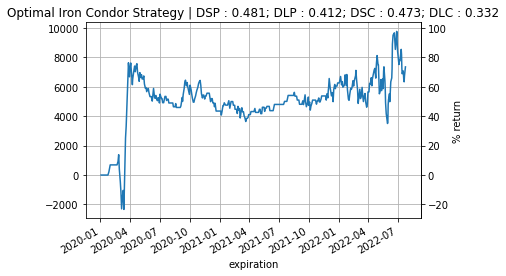

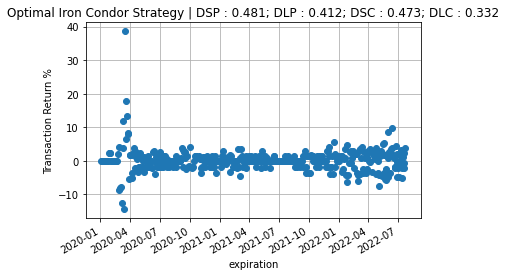

In [6]:
study = optuna.create_study(direction = "maximize")
study.optimize(lambda trial: objective(trial, df), n_trials = 1)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

In [7]:
dir(ss)

['ABC',
 'OptimalIronCondorStrategy',
 'SpxThetaStrategy',
 'StaticStrategyTest',
 'Strategy',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'abstractmethod',
 'np',
 'pd']